## install mujoco-py, D4RL, graph libs

* **Restart Runtime** after running this block to complete D4RL setup


In [ ]:

###### libs for install ######


!sudo apt-get update
!sudo apt-get install gcc

!sudo apt-get build-dep mesa
!sudo apt-get install llvm-dev
!sudo apt-get install freeglut3 freeglut3-dev

!sudo apt-get install python3-dev

!sudo apt-get install build-essential

# !sudo apt install curl git libgl1-mesa-dev libgl1-mesa-glx libglew-dev \
#         libosmesa6-dev software-properties-common net-tools unzip vim \
#         virtualenv wget xpra xserver-xorg-dev libglfw3-dev patchelf

#!sudo apt-get install -y libglew-dev

!pip install networkx
!pip install pybind11
!pip install graph-walker
!pip install glfw


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,375 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [61.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,974 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/

In [ ]:

###### restart runtime ######

exit()


In [ ]:
!pip install Cython==3.0.0a10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import libs


In [ ]:

# set mujoco env path if not already set

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import sys
import random
import csv
from datetime import datetime
import pickle
import collections
import math

import numpy as np
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import networkx as nx
import walker
from gym.envs.registration import registry, register



# training parameters

In [ ]:
env_name = 'RandomWalkEnv-v0'
rtg_target = 0
# dataset_path = f'/content/drive/MyDrive/6_8200_project/random_walk-medium.pkl'
# dataset_path = f'/content/drive/MyDrive/6_8200_project/random_walk-medium-walker.pkl'
dataset_path = f'/content/drive/MyDrive/6_8200_project/random_walk-medium-T50.pkl'

max_eval_ep_len = 10      # max len of one evaluation episode
num_eval_ep = 10            # num of evaluation episodes per iteration

batch_size = 64             # training batch size
lr = 1e-4                   # learning rate
wt_decay = 1e-4             # weight decay
warmup_steps = 10000        # warmup steps for lr scheduler

# total updates = max_train_iters x num_updates_per_iter
max_train_iters = 100
num_updates_per_iter = 100

context_len = 10        # K in decision transformer

n_blocks = 3            # num of transformer blocks
embed_dim = 128         # embedding (hidden) dim of transformer
n_heads = 1             # num of transformer heads
dropout_p = 0.1         # dropout probability


# saves model and csv in this directory
log_dir = "./dt_runs/"


if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# training and evaluation device
device_name = 'cuda'
device = torch.device(device_name)
print("device set to: ", device)



device set to:  cuda


# Generate Random Walk Dataset (with python Walker)


Toy example: generate the dataset of random walks on a graph.

In [ ]:
seed = 42
# create a random graph
# G = nx.random_partition_graph([20], .1, 0, seed=seed)
# generate random goal
# goal = np.random.choice([g for g in G.nodes()])

nodes = list(G.nodes())
nodes.remove(goal)
# goal = np.array([goal])

# # generate random start nodes
start_nodes = np.random.choice(nodes, size=8000)
# generate 8000 random walks
X = np.zeros((8000, 10))
for i, start_node in enumerate(start_nodes):
  X[i, :] = walker.random_walks(G, n_walks=1, walk_len=10, start_nodes=[start_node])

GOAL NODE: [11]


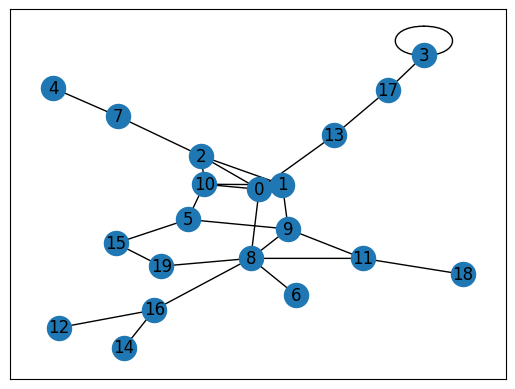

In [ ]:
# with open(f'/content/drive/MyDrive/6_8200_project/graph.pkl', 'wb') as f:
  # pickle.dump(G, f)
# with open(f'/content/drive/MyDrive/6_8200_project/goal.pkl', 'wb') as f:
#   pickle.dump(goal, f)

nx.draw_networkx(G)
print("GOAL NODE:", goal)
# new_edges = list(G.edges())[:]
# new_edges.remove((3,3))
# G.update(edges=new_edges)


In [ ]:

trajectories = []
for i in range(1000):
  path = X[i, :]
  rewards = []
  done = []
  actions = []
  traj = {}
  for i, s in enumerate(path):
    if s == goal:
      rewards.append(0)
      done.append(1)
    else:
      rewards.append(-1)
      done.append(0)
    if i == len(path) - 1:
      actions.append([np.random.choice(nodes)])
    else:
      actions.append([path[i+1]])
  rewards = np.array(rewards)
  done = np.array(done)
  actions = np.array(actions)
  traj['rewards'] = rewards
  traj['dones'] = done
  traj['actions'] = actions
  traj['observations'] = np.array([[s] for s in path])
  trajectories.append(traj)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

with open(f'/content/drive/MyDrive/6_8200_project/random_walk-medium-walker.pkl', 'wb') as f:
  pickle.dump(trajectories, f)


In [ ]:
# an example trajectory that terminated successfully
for traj in trajectories:
  if sum(traj['rewards'])> -10:
    print(traj)
    break

{'rewards': array([-1, -1, -1, -1, -1, -1,  0, -1,  0, -1]), 'dones': array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0]), 'actions': array([[13.],
       [ 0.],
       [10.],
       [ 5.],
       [ 9.],
       [11.],
       [18.],
       [11.],
       [ 8.],
       [ 3.]]), 'observations': array([[17.],
       [13.],
       [ 0.],
       [10.],
       [ 5.],
       [ 9.],
       [11.],
       [18.],
       [11.],
       [ 8.]])}


# Random Walk gym environment and Generate random walks dataset (with Gym Env)

In [ ]:
import gym

class RandomWalkEnv(gym.Env):
  def __init__(self, G, goal):
    self.action_space = gym.spaces.Discrete(20)
    self.observation_space = gym.spaces.Discrete(20)
    self.graph = G
    self.goal = np.array([goal])

  def step(self, action):
    if isinstance(action, np.ndarray):
      action = action.reshape((1,))
    elif isinstance(action, int):
      action = np.array([action])
    state = self.state

    if (state.item(), action.item()) in self.graph.edges() or (action.item(), state.item()) in self.graph.edges():
      self.state = np.array(action)
    done = self.is_done(self.state)
    if done:
      reward = 0
    else:
      reward = -1
    return self.state, reward, done, {}

  def reset(self):
    nodes = list(self.graph.nodes())
    nodes.remove(self.goal[0])
    state = np.array([np.random.choice(nodes)])
    self.state = state
    return state

  def is_done(self, state):

    return (state == self.goal).item()

env_name = 'RandomWalkEnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:RandomWalkEnv',
)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


In [ ]:
with open(f'/content/drive/MyDrive/6_8200_project/graph.pkl', 'rb') as f:
  G = pickle.load(f)
with open(f'/content/drive/MyDrive/6_8200_project/goal.pkl', 'rb') as f:
  goal = pickle.load(f)

In [ ]:
env = gym.make("RandomWalkEnv-v0", G=G, goal=goal)
trajectories = []
for _ in range(8000):
  traj = {}
  s = env.reset()
  path = [s]
  actions = []
  rewards = []#[0 if env.is_done(s) else -1]
  dones = []#[env.is_done(s)]
  for i in range(10):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(np.array([action]))
    path.append(obs)
    actions.append([action])
    rewards.append(reward)
    dones.append(done)
  # actions = actions[:10]
  # rewards = rewards[:10]
  # dones = dones[:10]
  path = path[:10]
  traj['rewards'] = np.array(rewards)
  traj['dones'] = np.array(dones)
  traj['actions'] = np.array(actions)
  traj['observations'] = np.array(path)
  trajectories.append(traj)
with open(f'/content/drive/MyDrive/6_8200_project/random_walk-medium.pkl', 'wb') as f:
  pickle.dump(trajectories, f)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 

In [ ]:
for traj in trajectories:
  if sum(traj['rewards'])> -10:
    print(traj)
    break

{'rewards': array([-1, -1, -1, -1, -1, -1, -1, -1,  0,  0]), 'dones': array([False, False, False, False, False, False, False, False,  True,
        True]), 'actions': array([[ 8],
       [12],
       [18],
       [13],
       [13],
       [ 8],
       [ 1],
       [ 1],
       [11],
       [ 3]]), 'observations': array([[ 0],
       [ 8],
       [ 8],
       [ 8],
       [ 8],
       [ 8],
       [ 8],
       [ 8],
       [ 8],
       [11]])}


# decision transformer model

In [ ]:

"""
this extremely minimal GPT model is based on:
Misha Laskin's tweet:
https://twitter.com/MishaLaskin/status/1481767788775628801?cxt=HHwWgoCzmYD9pZApAAAA

and its corresponding notebook:
https://colab.research.google.com/drive/1NUBqyboDcGte5qAJKOl8gaJC28V_73Iv?usp=sharing

the above colab has a bug while applying masked_fill which is fixed in the
following code

"""

class MaskedCausalAttention(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()

        self.n_heads = n_heads
        self.max_T = max_T

        self.q_net = nn.Linear(h_dim, h_dim)
        self.k_net = nn.Linear(h_dim, h_dim)
        self.v_net = nn.Linear(h_dim, h_dim)

        self.proj_net = nn.Linear(h_dim, h_dim)

        self.att_drop = nn.Dropout(drop_p)
        self.proj_drop = nn.Dropout(drop_p)

        ones = torch.ones((max_T, max_T))
        mask = torch.tril(ones).view(1, 1, max_T, max_T)

        # register buffer makes sure mask does not get updated
        # during backpropagation
        self.register_buffer('mask',mask)

    def forward(self, x):
        B, T, C = x.shape # batch size, seq length, h_dim * n_heads

        N, D = self.n_heads, C // self.n_heads # N = num heads, D = attention dim

        # rearrange q, k, v as (B, N, T, D)
        q = self.q_net(x).view(B, T, N, D).transpose(1,2)
        k = self.k_net(x).view(B, T, N, D).transpose(1,2)
        v = self.v_net(x).view(B, T, N, D).transpose(1,2)

        # weights (B, N, T, T)
        weights = q @ k.transpose(2,3) / math.sqrt(D)
        # causal mask applied to weights
        weights = weights.masked_fill(self.mask[...,:T,:T] == 0, float('-inf'))
        # normalize weights, all -inf -> 0 after softmax
        normalized_weights = F.softmax(weights, dim=-1)

        # attention (B, N, T, D)
        attention = self.att_drop(normalized_weights @ v)

        # gather heads and project (B, N, T, D) -> (B, T, N*D)
        attention = attention.transpose(1, 2).contiguous().view(B,T,N*D)

        out = self.proj_drop(self.proj_net(attention))
        return out


class Block(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()
        self.attention = MaskedCausalAttention(h_dim, max_T, n_heads, drop_p)
        self.mlp = nn.Sequential(
                nn.Linear(h_dim, 4*h_dim),
                nn.GELU(),
                nn.Linear(4*h_dim, h_dim),
                nn.Dropout(drop_p),
            )
        self.ln1 = nn.LayerNorm(h_dim)
        self.ln2 = nn.LayerNorm(h_dim)

    def forward(self, x):
    # Discussion: https://github.com/openai/CLIP/issues/91
        # instead of (Attention -> LayerNorm -> MLP -> LayerNorm)
        x = x + self.attention(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, act_dim, n_blocks, h_dim, context_len,
                 n_heads, drop_p, max_timestep=4096):
        super().__init__()

        self.state_dim = state_dim
        self.act_dim = act_dim
        self.h_dim = h_dim

        ### transformer blocks
        input_seq_len = 3 * context_len
        blocks = [Block(h_dim, input_seq_len, n_heads, drop_p) for _ in range(n_blocks)]
        self.transformer = nn.Sequential(*blocks)

        ### projection heads (project to embedding)
        self.embed_ln = nn.LayerNorm(h_dim)
        self.embed_timestep = nn.Embedding(max_timestep, h_dim)
        self.embed_rtg = torch.nn.Linear(1, h_dim)

        # # continuous state
        # self.embed_state = torch.nn.Linear(state_dim, h_dim)

        # # discrete state
        self.embed_state = torch.nn.Embedding(state_dim, h_dim)

        # # discrete actions
        self.embed_action = torch.nn.Embedding(act_dim, h_dim)
        use_action_tanh = False # False for discrete actions

        # # continuous actions
        # self.embed_action = torch.nn.Linear(act_dim, h_dim)
        # use_action_tanh = True # True for continuous actions

        ### prediction heads
        self.predict_rtg = torch.nn.Linear(h_dim, 11)
        self.predict_state = torch.nn.Linear(h_dim, state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(h_dim, act_dim, bias=False)] )
        )


    def forward(self, timesteps, states, actions, returns_to_go):
        B, T, _ = states.shape

        time_embeddings = self.embed_timestep(timesteps)
        # time embeddings are treated similar to positional embeddings
        state_embeddings = self.embed_state(states.to(torch.int32)).squeeze().float() + time_embeddings
        action_embeddings = self.embed_action(actions.to(torch.int32)).squeeze().float() + time_embeddings
        returns_embeddings = self.embed_rtg(returns_to_go) + time_embeddings


        # stack rtg, states and actions and reshape sequence as
        # (r1, s1, a1, r2, s2, a2 ...)
        h = torch.stack(
            (returns_embeddings, state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(B, 3 * T, self.h_dim)

        h = self.embed_ln(h)

        # transformer and prediction
        h = self.transformer(h)

        # get h reshaped such that its size = (B x 3 x T x h_dim) and
        # h[:, 0, t] is conditioned on r_0, s_0, a_0 ... r_t
        # h[:, 1, t] is conditioned on r_0, s_0, a_0 ... r_t, s_t
        # h[:, 2, t] is conditioned on r_0, s_0, a_0 ... r_t, s_t, a_t
        h = h.reshape(B, T, 3, self.h_dim).permute(0, 2, 1, 3)

        # get predictions
        return_preds = self.predict_rtg(h[:,2])     # predict next rtg given r, s, a
        state_preds = self.predict_state(h[:,2])    # predict next state given r, s, a
        action_preds = self.predict_action(h[:,1])  # predict action given r, s

        return state_preds, action_preds, return_preds




# utils

In [ ]:


def discount_cumsum(x, gamma):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
    return disc_cumsum

def evaluate_on_env(model, device, context_len, env, rtg_target,
                    num_eval_ep=10, max_test_ep_len=1000,
                    state_mean=None, state_std=None, render=False):

    eval_batch_size = 1  # required for forward pass

    results = {}
    total_reward = 0
    total_timesteps = 0

    state_dim = 1
    act_dim = 1

    if state_mean is None:
        state_mean = torch.zeros((state_dim,)).to(device)
    else:
        state_mean = torch.from_numpy(state_mean).to(device)

    if state_std is None:
        state_std = torch.ones((state_dim,)).to(device)
    else:
        state_std = torch.from_numpy(state_std).to(device)

    # same as timesteps used for training the transformer
    # also, crashes if device is passed to arange()
    timesteps = torch.arange(start=0, end=max_test_ep_len, step=1)
    timesteps = timesteps.repeat(eval_batch_size, 1).to(device)

    model.eval()

    with torch.no_grad():

        for _ in range(num_eval_ep):

            # zeros place holders
            actions = torch.zeros((eval_batch_size, max_test_ep_len, act_dim),
                                dtype=torch.float32, device=device)

            states = torch.zeros((eval_batch_size, max_test_ep_len, state_dim),
                                dtype=torch.float32, device=device)

            rewards_to_go = torch.zeros((eval_batch_size, max_test_ep_len, 1),
                                dtype=torch.float32, device=device)

            # init episode
            running_state = env.reset()
            running_reward = 0
            running_rtg = rtg_target# / rtg_scale

            for t in range(max_test_ep_len):

                total_timesteps += 1

                # add state in placeholder and normalize
                states[0, t] = torch.from_numpy(running_state).to(device)
                states[0, t] = (states[0, t] - state_mean) / state_std

                # calcualate running rtg and add in placeholder
                running_rtg = running_rtg - (running_reward)# / rtg_scale)
                rewards_to_go[0, t] = running_rtg

                if t < context_len:
                    _, act_preds, _ = model.forward(timesteps[:,:context_len],
                                                states[:,:context_len],
                                                actions[:,:context_len],
                                                rewards_to_go[:,:context_len])
                    act = act_preds[0, t].detach()
                else:
                    _, act_preds, _ = model.forward(timesteps[:,t-context_len+1:t+1],
                                                states[:,t-context_len+1:t+1],
                                                actions[:,t-context_len+1:t+1],
                                                rewards_to_go[:,t-context_len+1:t+1])
                    act = act_preds[0, -1].detach()

                running_state, running_reward, done, _ = env.step(act.argmax().cpu().numpy())

                # add action in placeholder
                actions[0, t] = act.argmax()

                total_reward += running_reward

                if render:
                    env.render()
                if done:
                    break

    results['eval/avg_reward'] = total_reward / num_eval_ep
    results['eval/avg_ep_len'] = total_timesteps / num_eval_ep

    return results



# dataset

In [ ]:
## check data

# load dataset
with open(dataset_path, 'rb') as f:
    trajectories = pickle.load(f)

min_len = 10**4

for traj in trajectories:
    min_len = min(min_len, traj['observations'].shape[0])



print(dataset_path)
print("num of trajectories in dataset: ", len(trajectories))
print("minimum trajectory length in dataset: ", min_len)



/content/drive/MyDrive/6_8200_project/random_walk-medium.pkl
num of trajectories in dataset:  8000
minimum trajectory length in dataset:  10


In [ ]:


class D4RLTrajectoryDataset(Dataset):
    def __init__(self, dataset_path, context_len):

        self.context_len = context_len

        # load dataset
        with open(dataset_path, 'rb') as f:
            self.trajectories = pickle.load(f)

        # calculate min len of traj, state mean and variance
        # and returns_to_go for all traj
        min_len = 10**6
        states = []
        for traj in self.trajectories:
            traj_len = traj['observations'].shape[0]
            min_len = min(min_len, traj_len)
            states.append(traj['observations'])
            # calculate returns to go and rescale them
            traj['returns_to_go'] = discount_cumsum(traj['rewards'], 1.0)


        # # used for input normalization
        states = np.concatenate(states, axis=0)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

        # # normalize states
        # for traj in self.trajectories:
        #     traj['observations'] = (traj['observations'] - self.state_mean) / self.state_std


    def get_state_stats(self):
        return self.state_mean, self.state_std

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        traj_len = traj['observations'].shape[0]

        if traj_len >= self.context_len:
            # sample random index to slice trajectory
            si = random.randint(0, traj_len - self.context_len)

            states = torch.from_numpy(traj['observations'][si : si + self.context_len])
            actions = torch.from_numpy(traj['actions'][si : si + self.context_len])
            returns_to_go = torch.from_numpy(traj['returns_to_go'][si : si + self.context_len])
            timesteps = torch.arange(start=si, end=si+self.context_len, step=1)


            # all ones since no padding
            traj_mask = torch.ones(self.context_len, dtype=torch.long)

        else:
            padding_len = self.context_len - traj_len

            # padding with zeros
            states = torch.from_numpy(traj['observations'])
            states = torch.cat([states,
                                torch.zeros(([padding_len] + list(states.shape[1:])),
                                dtype=states.dtype)],
                               dim=0)

            actions = torch.from_numpy(traj['actions'])
            actions = torch.cat([actions,
                                torch.zeros(([padding_len] + list(actions.shape[1:])),
                                dtype=actions.dtype)],
                               dim=0)

            returns_to_go = torch.from_numpy(traj['returns_to_go'])
            returns_to_go = torch.cat([returns_to_go,
                                torch.zeros(([padding_len] + list(returns_to_go.shape[1:])),
                                dtype=returns_to_go.dtype)],
                               dim=0)

            timesteps = torch.arange(start=0, end=self.context_len, step=1)

            traj_mask = torch.cat([torch.ones(traj_len, dtype=torch.long),
                                   torch.zeros(padding_len, dtype=torch.long)],
                                  dim=0)

        return  timesteps, states, actions, returns_to_go, traj_mask




# train

In [ ]:

start_time = datetime.now().replace(microsecond=0)

start_time_str = start_time.strftime("%y-%m-%d-%H-%M-%S")

prefix = "dt_random_walk"

save_model_name =  prefix + "_model_" + start_time_str + ".pt"
save_model_path = os.path.join(log_dir, save_model_name)
save_best_model_path = save_model_path[:-3] + "_best.pt"

log_csv_name = prefix + "_log_" + start_time_str + ".csv"
log_csv_path = os.path.join(log_dir, log_csv_name)


csv_writer = csv.writer(open(log_csv_path, 'a', 1))
csv_header = (["duration", "num_updates", "action_loss",
               "eval_avg_reward", "eval_avg_ep_len", "eval_d4rl_score"])

csv_writer.writerow(csv_header)


print("=" * 60)
print("start time: " + start_time_str)
print("=" * 60)

print("device set to: " + str(device))
print("dataset path: " + dataset_path)
print("model save path: " + save_model_path)
print("log csv save path: " + log_csv_path)


traj_dataset = D4RLTrajectoryDataset(dataset_path, context_len)

traj_data_loader = DataLoader(traj_dataset,
						batch_size=batch_size,
						shuffle=True,
						pin_memory=True,
						drop_last=True)

data_iter = iter(traj_data_loader)

## get state stats from dataset
state_mean, state_std = traj_dataset.get_state_stats()

env = gym.make(env_name, G=G, goal=goal)

state_dim = 20 # state is 1d, but will create an embedding for each of the 20 nodes
act_dim = 20 # action is 1d, but want to give a distribution over the 20 options

model = DecisionTransformer(
			state_dim=state_dim,
			act_dim=act_dim,
			n_blocks=n_blocks,
			h_dim=embed_dim,
			context_len=context_len,
			n_heads=n_heads,
			drop_p=dropout_p,
		).to(device)

optimizer = torch.optim.AdamW(
					model.parameters(),
					lr=lr,
					weight_decay=wt_decay
				)

scheduler = torch.optim.lr_scheduler.LambdaLR(
		optimizer,
		lambda steps: min((steps+1)/warmup_steps, 1)
	)

max_d4rl_score = -np.inf
total_updates = 0
loss_fn = torch.nn.CrossEntropyLoss()

rtg_dim = 11

T = 10

# [P(k=0), P(k=-1)... P(k=-10)]
P_prior = torch.tensor([T + 1 + k for k in range(-10, 1)][::-1])[None, None, :] # (1, 1, 11)
P_prior = P_prior / P_prior.sum()
P_prior = P_prior.to(device)
print(P_prior.shape)

for i_train_iter in range(max_train_iters):

	log_action_losses = []
	model.train()

	for _ in range(num_updates_per_iter):
		try:
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
		except StopIteration:
			data_iter = iter(traj_data_loader)
			timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)

		timesteps = timesteps.to(device)	# B x T
		states = states.to(device)			# B x T x 1
		actions = actions.to(device)		# B x T x 1
		returns_to_go = returns_to_go.to(device).unsqueeze(dim=-1).float() # B x T x 1
		traj_mask = traj_mask.to(device)	# B x T

		# Turn targets into indices
		returns_target = torch.clone(torch.abs(returns_to_go)).detach().to(device)

		state_preds, action_preds, return_preds = model.forward(
														timesteps=timesteps,
														states=states,
														actions=actions,
														returns_to_go=returns_to_go
													)

		return_preds = P_prior * 10 + return_preds
		return_preds = return_preds.view(-1, rtg_dim) # (B x T, rtg_dim)
		returns_target = returns_target.view(-1,).type(torch.LongTensor).to(device) # (B x T,)

		# Loss: predict returns-to-go, and maximize reward.
		rtg_loss = loss_fn(return_preds, returns_target)

		optimizer.zero_grad()
		rtg_loss.backward()
		# torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
		optimizer.step()
		scheduler.step()

		log_action_losses.append(rtg_loss.detach().cpu().item())

	# evaluate on env
	results = evaluate_on_env(model, device, context_len, env, rtg_target,
	                        num_eval_ep, max_eval_ep_len
							)
	eval_avg_reward = results['eval/avg_reward']
	eval_avg_ep_len = results['eval/avg_ep_len']
	eval_d4rl_score = eval_avg_reward

	mean_action_loss = np.mean(log_action_losses)
	time_elapsed = str(datetime.now().replace(microsecond=0) - start_time)

	total_updates += num_updates_per_iter

	log_str = ("=" * 60 + '\n' +
			"time elapsed: " + time_elapsed  + '\n' +
			"num of updates: " + str(total_updates) + '\n' +
			"action loss: " +  format(mean_action_loss, ".5f") + '\n' +
			"eval avg reward: " + format(eval_avg_reward, ".5f") + '\n' +
			"eval avg ep len: " + format(eval_avg_ep_len, ".5f") + '\n'
			)

	print(log_str)

	log_data = [time_elapsed, total_updates, mean_action_loss,
				eval_avg_reward, eval_avg_ep_len]

	csv_writer.writerow(log_data)

	# save model
	print("max score: " + format(max_d4rl_score, ".5f"))
	if eval_d4rl_score >= max_d4rl_score:
		print("saving max score model at: " + save_best_model_path)
		torch.save(model.state_dict(), save_best_model_path)
		max_d4rl_score = eval_d4rl_score

	print("saving current model at: " + save_model_path)
	torch.save(model.state_dict(), save_model_path)


print("=" * 60)
print("finished training!")
print("=" * 60)
end_time = datetime.now().replace(microsecond=0)
time_elapsed = str(end_time - start_time)
end_time_str = end_time.strftime("%y-%m-%d-%H-%M-%S")
print("started training at: " + start_time_str)
print("finished training at: " + end_time_str)
print("total training time: " + time_elapsed)
print("max score: " + format(max_d4rl_score, ".5f"))
print("saved max score model at: " + save_best_model_path)
print("saved last updated model at: " + save_model_path)
print("=" * 60)

# csv_writer.close()




start time: 24-04-12-15-46-01
device set to: cuda
dataset path: /content/drive/MyDrive/6_8200_project/random_walk-medium-walker.pkl
model save path: ./dt_runs/dt_random_walk_model_24-04-12-15-46-01.pt
log csv save path: ./dt_runs/dt_random_walk_log_24-04-12-15-46-01.csv
torch.Size([1, 1, 11])
time elapsed: 0:00:03
num of updates: 100
action loss: 2.71756
eval avg reward: -8.40000
eval avg ep len: 8.60000

max score: -inf
saving max score model at: ./dt_runs/dt_random_walk_model_24-04-12-15-46-01_best.pt
saving current model at: ./dt_runs/dt_random_walk_model_24-04-12-15-46-01.pt
time elapsed: 0:00:06
num of updates: 200
action loss: 2.61717
eval avg reward: -9.20000
eval avg ep len: 9.30000

max score: -8.40000
saving current model at: ./dt_runs/dt_random_walk_model_24-04-12-15-46-01.pt
time elapsed: 0:00:08
num of updates: 300
action loss: 2.43030
eval avg reward: -10.00000
eval avg ep len: 10.00000

max score: -8.40000
saving current model at: ./dt_runs/dt_random_walk_model_24-04-12-

AttributeError: '_csv.writer' object has no attribute 'close'

# test

In [ ]:

num_test_eval_ep = 10			# num of evaluation episodes
eval_max_eval_ep_len = 1000		# max len of one episode


context_len = 10        # K in decision transformer
n_blocks = 3            # num of transformer blocks
embed_dim = 128         # embedding (hidden) dim of transformer
n_heads = 1             # num of transformer heads
dropout_p = 0.1         # dropout probability


eval_chk_pt_dir = '/content/drive/MyDrive/6_8200_project/'
# eval_chk_pt_name = "dt_random_walk_model_24-04-11-20-45-05_best.pt"
# eval_chk_pt_name = 'dt_random_walk_model_24-04-12-15-46-01_best.pt' # WALKER data (8000 trajs)
eval_chk_pt_name = 'dt_random_walk_model_24-04-12-15-23-07_best.pt' # ENV generated data (8000 trajs)

# eval_chk_pt_dir = "./dt_runs/"
# eval_chk_pt_name = 'dt_random_walk_model_24-04-12-15-46-01_best.pt'

eval_chk_pt_list = [eval_chk_pt_name]

eval_env = gym.make("RandomWalkEnv-v0", G=G, goal=goal)
eval_rtg_target = 0
state_dim = 20
act_dim = 20

all_scores = []

for eval_chk_pt_name in eval_chk_pt_list:

	eval_model = DecisionTransformer(
				state_dim=state_dim,
				act_dim=act_dim,
				n_blocks=n_blocks,
				h_dim=embed_dim,
				context_len=context_len,
				n_heads=n_heads,
				drop_p=dropout_p,
			).to(device)


	eval_chk_pt_path = os.path.join(eval_chk_pt_dir, eval_chk_pt_name)

	# load checkpoint
	eval_model.load_state_dict(torch.load(eval_chk_pt_path, map_location=device))

	print("model loaded from: " + eval_chk_pt_path)

	# evaluate on env
	results = evaluate_on_env(eval_model, device, context_len,
							eval_env, eval_rtg_target,
							num_test_eval_ep, max_test_ep_len=10)
	print(results)

	norm_score = results['eval/avg_reward']
	print("score: ", norm_score)

	all_scores.append(norm_score)

print("=" * 60)
all_scores = np.array(all_scores)
print("evaluated on env: RandomWalkEnv-v0 ")
print("total num of checkpoints evaluated: " + str(len(eval_chk_pt_list)))
print("score mean: " + format(all_scores.mean(), ".5f"))
print("score std: " + format(all_scores.std(), ".5f"))
print("=" * 60)




model loaded from: /content/drive/MyDrive/6_8200_project/dt_random_walk_model_24-04-12-15-23-07_best.pt
{'eval/avg_reward': -7.0, 'eval/avg_ep_len': 7.3}
score:  -7.0
evaluated on env: RandomWalkEnv-v0 
total num of checkpoints evaluated: 1
score mean: -7.00000
score std: 0.00000


# Print paths found on the graph

In [ ]:
import shutil
# shutil.copyfile('./dt_runs/dt_random_walk_model_24-04-12-15-46-01_best.pt', '/content/drive/MyDrive/6_8200_project/dt_random_walk_model-WALKERdata_24-04-12-15-46-01_best.pt')

with open('/content/drive/MyDrive/6_8200_project/dt_random_walk_model_24-04-12-15-23-07_best.pt', 'rb') as f:
  model = torch.load(f, map_location=device)

eval_model = DecisionTransformer(
				state_dim=20,
				act_dim=20,
				n_blocks=3,
				h_dim=128,
				context_len=10,
				n_heads=1,
				drop_p=.1,
			).to(device)

eval_model.load_state_dict(model)

optimal_paths = {}
start_nodes = list([[n] for n in G.nodes() if n != goal[0]])
for start_node in start_nodes:
  optimal_paths[start_node[0]] = (nx.shortest_path(G, source=start_node[0], target=goal[0]))

# with open(f'/content/drive/MyDrive/6_8200_project/graph.pkl', 'rb') as f:
#   G = pickle.load(f)
# with open(f'/content/drive/MyDrive/6_8200_project/goal.pkl', 'rb') as f:
#   goal = pickle.load(f)
# with open(f'/content/drive/MyDrive/6_8200_project/random_walk-medium.pkl', 'rb') as f:
#   trajectories = pickle.load(f)
# with open(f'/content/drive/MyDrive/6_8200_project/optimal_paths.pkl', 'rb') as f:
#   optimal_paths = pickle.load(f)


<All keys matched successfully>

In [ ]:
max_test_ep_len = 10
eval_batch_size = 1  # required for forward pass

results = {}
total_reward = 0
total_timesteps = 0

env = gym.make("RandomWalkEnv-v0", G=G, goal=goal)
state_dim = 1
act_dim = 1

timesteps = torch.arange(start=0, end=max_test_ep_len, step=1)
timesteps = timesteps.repeat(eval_batch_size, 1).to(device)

num_eval_ep = 100
found_paths = []

eval_model.eval()

with torch.no_grad():

    for _ in range(num_eval_ep):

        # zeros place holders
        actions = torch.zeros((eval_batch_size, max_test_ep_len, act_dim),
                            dtype=torch.float32, device=device)

        states = torch.zeros((eval_batch_size, max_test_ep_len, state_dim),
                            dtype=torch.float32, device=device)

        rewards_to_go = torch.zeros((eval_batch_size, max_test_ep_len, 1),
                            dtype=torch.float32, device=device)

        # init episode
        running_state = env.reset()
        running_reward = 0
        running_rtg = rtg_target
        path = [running_state]
        for t in range(max_test_ep_len):

            total_timesteps += 1

            # add state in placeholder and normalize
            states[0, t] = torch.from_numpy(running_state).to(device)

            # calcualate running rtg and add in placeholder
            running_rtg = running_rtg - (running_reward)
            rewards_to_go[0, t] = running_rtg

            # if t < context_len:
            _, act_preds, _ = eval_model.forward(timesteps[:,:context_len],
                                        states[:,:context_len],
                                        actions[:,:context_len],
                                        rewards_to_go[:,:context_len])
            act = act_preds[0, t].detach()

            running_state, running_reward, done, _ = env.step(act.argmax().cpu().numpy())
            path.append(running_state)
            # add action in placeholder
            actions[0, t] = act.argmax()

            total_reward += running_reward
            if done:
                break
        # print(path)
        found_paths.append(path)
    print(f'Avg reward for {num_eval_ep} episodes: {total_reward / num_eval_ep}')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 

Avg reward for 100 episodes: -8.5


Text(0.5, 1.0, 'Path Length Distribution')

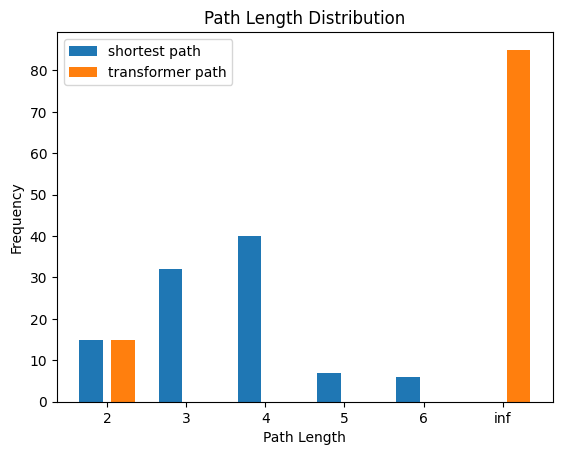

In [ ]:
from collections import defaultdict
shortest_path_length_counts = defaultdict(lambda: 0)
transformer_path_length_counts = defaultdict(lambda: 0)
for i, path in enumerate(found_paths):
  shortest_path_length_counts[len(optimal_paths[path[0][0]])] += 1
  transformer_path_length_counts[len(path)] += 1

from matplotlib import pyplot as plt

X = []
Y_sp = []
Y_transformer = []
for key in sorted(set(list(shortest_path_length_counts.keys()) + list(transformer_path_length_counts.keys()))):
  if key not in shortest_path_length_counts.keys():
    shortest_path_length_counts[key] = 0
    Y_sp.append(0)
  else:
    Y_sp.append(shortest_path_length_counts[key])
  if key not in transformer_path_length_counts.keys():
    transformer_path_length_counts[key] = 0
    Y_transformer.append(0)
  else:
    Y_transformer.append(transformer_path_length_counts[key])
  X.append(key)

X_axis = np.arange(len(X))
X[-1] = 'inf'

plt.bar(X_axis - .2, Y_sp, .3 , label='shortest path')
plt.bar(X_axis + .2, Y_transformer, .3, label='transformer path')
plt.xticks(X_axis, X)
plt.legend(loc='best')
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.title("Path Length Distribution")

GOAL NODE: [11]


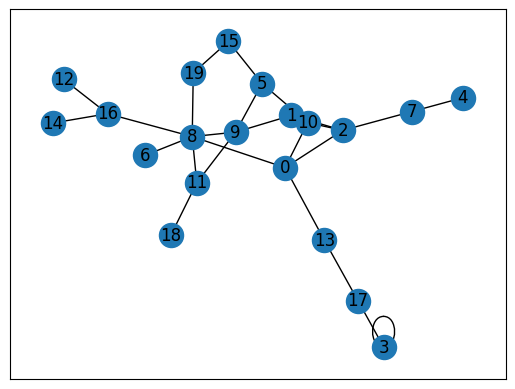

In [ ]:

nx.draw_networkx(G)
print("GOAL NODE:", goal)

Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges
Graph has 20 nodes with 43 edges


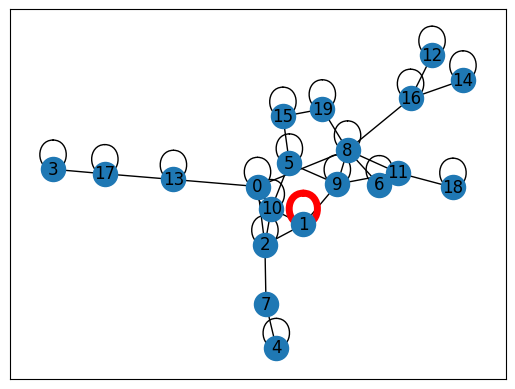

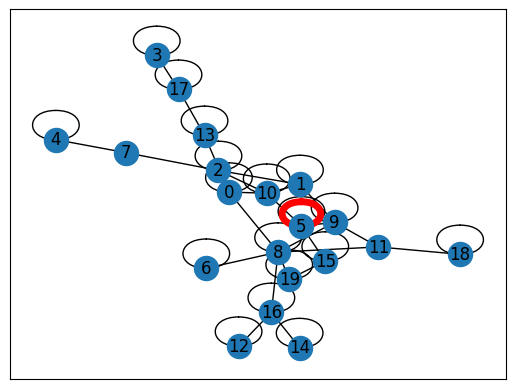

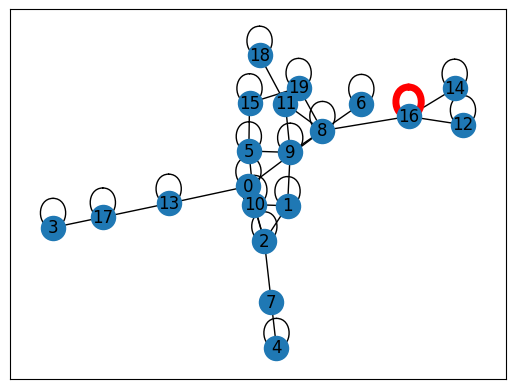

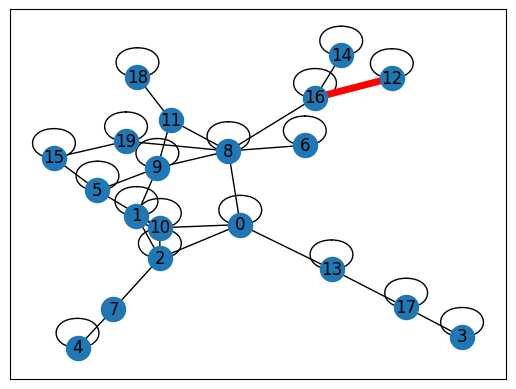

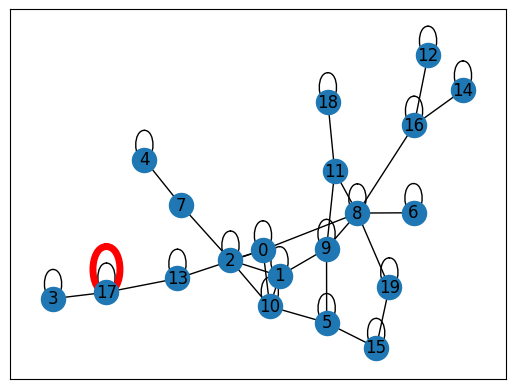

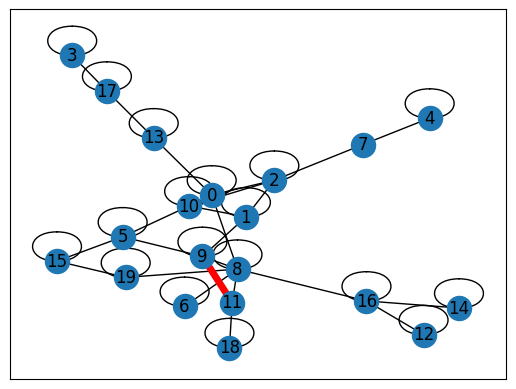

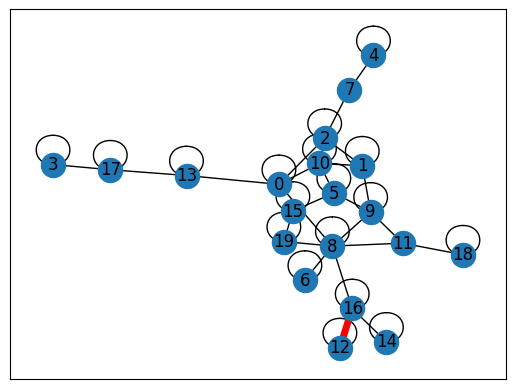

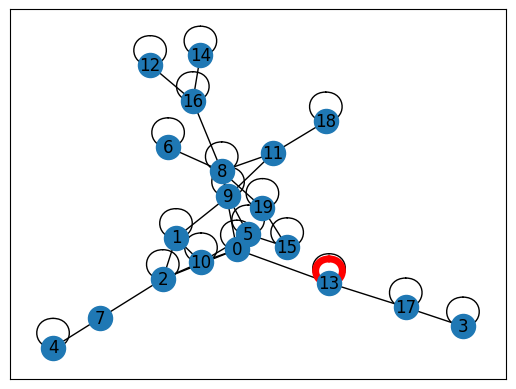

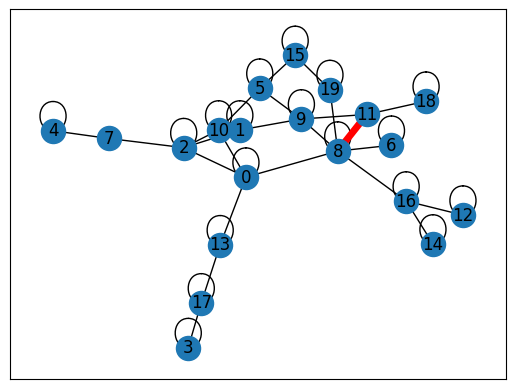

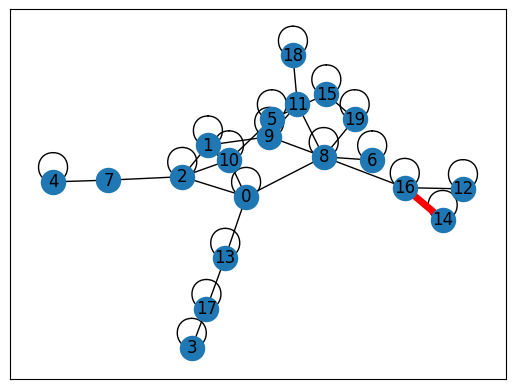

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

routes = [np.array(found_paths[i]).reshape(-1) for i in range(len(found_paths))]

edges = []
for r in routes:
    route_edges = [(r[n],r[n+1]) for n in range(len(r)-1)]
    G.add_nodes_from(r)
    G.add_edges_from(route_edges)
    edges.append(route_edges)
for i, edgelist in enumerate(edges):
  print("Graph has %d nodes with %d edges" %(G.number_of_nodes(),
  G.number_of_edges()))
  plt.figure()
  pos = nx.spring_layout(G)
  nx.draw_networkx_nodes(G,pos=pos)
  nx.draw_networkx_labels(G,pos=pos)
  nx.draw_networkx_edges(G,pos=pos)

  colors = ['r', 'b', 'y']
  linewidths = [5]
  nx.draw_networkx_edges(G,pos=pos,edgelist=edgelist,edge_color = colors[0], width=linewidths[0])
  plt.savefig(f'this{i}.png')